In [ ]:
import numpy as np

def generate_conflict_matrix(num_people=400, num_conflicts=600):
    matrix = np.zeros((num_people, num_people))
    indices = np.random.choice(num_people * num_people, num_conflicts, replace=False)

    while matrix.sum() < 2 * num_conflicts:
        indice = np.random.choice(num_people * num_people, 1, replace=False)[0]
        i, j = divmod(indice, num_people)
        if i != j:
            matrix[i, j] = 1
            matrix[j, i] = 1  # Ensure the matrix is symmetric

    return matrix

In [ ]:
import itertools
import torch
from torch.utils.data import Dataset, DataLoader

# Define the special tokens
BORDER_TOKEN = 400
# END_TOKEN = 401

def generate_random_groups(num_groups=80, group_size=5, total_people=400):
    people = list(range(total_people))
    np.random.shuffle(people)

    groups = []
    for i in range(num_groups):
        group = people[i * group_size:(i + 1) * group_size]
        permutations = list(itertools.permutations(group))
        groups.extend(permutations)

    return groups

class SeatingDataset(Dataset):
    def __init__(self, group_permutations, num_people=400, num_conflicts=600):
        self.data = [
            ([BORDER_TOKEN] + list(perm) + [BORDER_TOKEN], generate_conflict_matrix(num_people, num_conflicts))
            for perm in group_permutations
        ]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        permutation, conflict_matrix = self.data[idx]
        return torch.tensor(permutation, dtype=torch.long), torch.tensor(conflict_matrix, dtype=torch.float32)

# Create the dataset
group_permutations = generate_random_groups()
dataset = SeatingDataset(group_permutations)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example of a batch
for batch in dataloader:
    permutations, conflict_matrices = batch
    print(permutations)
    print(conflict_matrices)
    break


In [ ]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers=1):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim + 400, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, conflict_matrix):
        x = self.embedding(x)
        if len(conflict_matrix.size()) == 2:
            conflict_matrix = conflict_matrix.unsqueeze(1).repeat(1, x.size(1), 1)
        x = torch.cat((x, conflict_matrix), dim=2)
        h, _ = self.lstm(x)
        out = self.fc(h[:, -1, :])
        return out


# Define model parameters
input_dim = 401  # Number of unique people + start/end tokens
embedding_dim = 128  # Size of embedding vector
hidden_dim = 256  # Number of hidden units in LSTM
output_dim = 401  # Number of unique people + start/end tokens

# Create the model
model = LSTMModel(input_dim, embedding_dim, hidden_dim, output_dim)
print(model)


LSTMModel(
  (embedding): Embedding(402, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=402, bias=True)
)


In [ ]:
def compute_loss(P_hat, conflict_matrix, permutations):
    batch_size, seq_length = permutations.size()

    # Convert permutations to one-hot encoding
    one_hot_permutations = torch.zeros(batch_size, seq_length, P_hat.size(2))
    for i in range(batch_size):
        for j in range(seq_length):
            one_hot_permutations[i, j, permutations[i, j]] = 1

    # Compute conflicts loss
    P_hat_transpose = P_hat.permute(0, 2, 1)
    conflicts = torch.matmul(torch.matmul(P_hat, conflict_matrix.float()), P_hat_transpose)
    conflict_loss = conflicts.sum()

    # Compute group loss
    group_loss = 0
    for i in range(batch_size):
        group_indices = permutations[i, 1:-1]  # Exclude START_TOKEN and END_TOKEN
        for j in range(0, len(group_indices) - 1, 5):
            group = group_indices[j:j+5]
            for k in range(len(group) - 1):
                if abs(group[k] - group[k + 1]) != 1:
                    group_loss += 1

    return conflict_loss + group_loss

# Example usage
P_hat = torch.eye(24).unsqueeze(0).repeat(32, 1, 1)  # Dummy predicted permutation matrix for batch size 32
conflict_matrix = torch.eye(24).unsqueeze(0).repeat(32, 1, 1)  # Dummy conflict matrix for batch size 32
permutations = torch.randint(0, 24, (32, 7))  # Dummy permutations for batch size 32

loss = compute_loss(P_hat, conflict_matrix, permutations)
print(loss)


In [ ]:
import torch.optim as optim

# Training parameters
num_epochs = 100
learning_rate = 0.001

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        permutations, conflict_matrices = batch
        optimizer.zero_grad()
        P_hat = model(permutations, conflict_matrices)
        loss = compute_loss(P_hat, conflict_matrices, permutations)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch}, Loss: {avg_loss}')


# connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/seating_arrangement

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/seating_arrangement


# generate new conflict matrix

In [ ]:
import numpy as np

def generate_groups(n_people=400, n_groups=80, group_size=5):
    people = np.arange(n_people)
    np.random.shuffle(people)
    groups = [people[i * group_size:(i + 1) * group_size] for i in range(n_groups)]
    return groups

def generate_conflict_matrix_with_groups(groups, n_people=400, n_conflicts=600):
    conflict_matrix = np.full((n_people, n_people), 0, dtype=np.float32)  # Initialize with neutral value 2
    np.fill_diagonal(conflict_matrix, 0)  # No self-conflict

    # Assign group value 10
    for group in groups:
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                conflict_matrix[group[i], group[j]] = -10
                conflict_matrix[group[j], group[i]] = -10

    # Add conflicts with value -1
    count = 0
    while count < n_conflicts:
        i, j = np.random.choice(n_people, 2, replace=False)
        if conflict_matrix[i, j] == 0 and i != j :  # Only add conflict if it's a neutral relationship
            conflict_matrix[i, j] = 10
            conflict_matrix[j, i] = 10
            count += 1

    return conflict_matrix

groups = generate_groups()
conflict_matrix = generate_conflict_matrix_with_groups(groups)
print(conflict_matrix)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# Loss function considering groups

In [ ]:
import torch
import torch.nn.functional as F

def compute_loss(P_hat, conflict_matrix):
    """
    Compute the loss for the given placement matrix and conflict matrix.

    Parameters:
    - P_hat: The predicted placement matrix (batch_size, n, n)
    - conflict_matrix: The conflict matrix (batch_size, n, n)

    Returns:
    - loss: The computed loss value
    """
    batch_size = P_hat.size(0)
    n = P_hat.size(1)  # This should be 400

    # Assignment loss
    row_sum_loss = F.mse_loss(torch.sum(P_hat, dim=2), torch.ones(batch_size, n, device=P_hat.device))
    col_sum_loss = F.mse_loss(torch.sum(P_hat, dim=1), torch.ones(batch_size, n, device=P_hat.device))
    assignment_loss = row_sum_loss + col_sum_loss

    # Conflict loss
    conflict_loss = 0
    for b in range(batch_size):
        P = P_hat[b]
        P_t = P.transpose(0, 1)
        # print("P values", P[0, :100], "p shape", P.shape)
        # print("P_t values", P_t[0, :100], "p shape", P_t.shape)
        C = torch.matmul(torch.matmul(P, conflict_matrix[b].float()), P_t)

        C = C.view(400, 400)
        # print("C values",C[0, :100])

        for i in range(20):
            for j in range(20):
                current_index = i * 20 + j
                if j < 19:  # Right neighbor
                    right_index = i * 20 + (j + 1)
                    conflict_loss += C[current_index, right_index]
                if i < 19:  # Front neighbor
                    front_index = (i + 1) * 20 + j
                    conflict_loss += C[current_index, front_index]
                if j > 0:  # Left neighbor
                    left_index = i * 20 + (j - 1)
                    conflict_loss += C[current_index, left_index]
                if i > 0:  # Back neighbor
                    back_index = (i - 1) * 20 + j
                    conflict_loss += C[current_index, back_index]

    total_loss = assignment_loss * 100 + conflict_loss
    return total_loss


# model code

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

## Define a CNN-based neural network model
class PlacementNet(nn.Module):
    def __init__(self):
        super(PlacementNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 50 * 50, 1024)  # Adjusted based on input size and pooling
        self.fc2 = nn.Linear(1024, 400 * 400)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 400, 400)
        return F.softmax(x, dim=-1)

# run the model

In [ ]:
# Initialize the model, optimizer, and loss function
model = PlacementNet().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Reduced learning rate

# Training loop
num_epochs = 700
batch_size = 10
losses = []
test_losses = []
conflict_matrices = [torch.from_numpy(generate_conflict_matrix_with_groups(groups)).float().unsqueeze(0) for i in range(100)]
conflict_matrices_test = [torch.from_numpy(generate_conflict_matrix_with_groups(groups)).float().unsqueeze(0) for i in range(10)]

# Create directories to save models
os.makedirs('models', exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for i, conflict_matrix in enumerate(conflict_matrices):
        conflict_matrix = conflict_matrix.cuda().unsqueeze(0)  # Add channel dimension
        optimizer.zero_grad()
        P_hat = model(conflict_matrix)
        loss = compute_loss(P_hat, conflict_matrix)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # conflict_matrix = conflict_matrix.cuda()
        # optimizer.zero_grad()
        # P_hat = model(conflict_matrix.view(1, -1))
        # loss = compute_loss(P_hat, conflict_matrix)
        # loss.backward()
        # optimizer.step()
        # total_loss += loss.item()

    avg_loss = total_loss / len(conflict_matrices)
    losses.append(avg_loss)

    model.eval()
    with torch.no_grad():
        total_loss_test = 0
        for i, conflict_matrix in enumerate(conflict_matrices_test):
            conflict_matrix = conflict_matrix.cuda().unsqueeze(0)
            P_hat = model(conflict_matrix)
            loss = compute_loss(P_hat, conflict_matrix)
            total_loss_test += loss.item()
    avg_test_loss = total_loss_test / len(conflict_matrices_test)
    test_losses.append(avg_test_loss)
    print(f"Epoch {epoch}, Loss: {avg_loss}, Validation Loss: {avg_test_loss}")

    # Save the model every 10 epochs
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f'models/placement_model.pth')

# Plot the training and validation loss
plt.figure()
plt.plot(losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

# Example usage: Generating a seating arrangement from a conflict matrix
def generate_placement(model, conflict_matrix):
    model.eval()
    with torch.no_grad():
        conflict_matrix = torch.from_numpy(conflict_matrix).float().unsqueeze(0).cuda()
        P_hat = model(conflict_matrix.view(1, -1)).squeeze(0).cpu().numpy()
        placement = np.argmax(P_hat, axis=1)
    return placement.tolist()

# Example usage
conflict_matrix = generate_conflict_matrix_with_groups(groups)
placement = generate_placement(model, conflict_matrix)
print("Generated Placement:", placement)

Epoch 0, Loss: -3452.4600090789795, Validation Loss: -3941.8952880859374
Epoch 1, Loss: -4020.4323608398436, Validation Loss: -4061.4788330078127
Epoch 2, Loss: -4133.234313964844, Validation Loss: -4195.5685546875
Epoch 3, Loss: -4278.676977539062, Validation Loss: -4312.49951171875
Epoch 5, Loss: -4313.5, Validation Loss: -4310.5
Epoch 6, Loss: -4314.3004541015625, Validation Loss: -4310.5
Epoch 7, Loss: -4314.3, Validation Loss: -4310.5
Epoch 8, Loss: -4314.300009765625, Validation Loss: -4310.5
Epoch 9, Loss: -4314.3, Validation Loss: -4310.5
Epoch 10, Loss: -4314.2957763671875, Validation Loss: -4310.5
Epoch 11, Loss: -4314.3, Validation Loss: -4310.5
Epoch 12, Loss: -4314.530014648438, Validation Loss: -4311.0


KeyboardInterrupt: 

## next method

In [1]:
def custom_loss(logits, probability_matrix):
    seating_probabilities = gumbel_softmax(logits, tau=1.0, hard=True)  # Use hard=True for actual seating arrangement
    penalty = 0
    for i in range(logits.size(0)):
        for j in range(logits.size(1) - 1):
            penalty += (1 - probability_matrix[j, j + 1]) * seating_probabilities[i, j, j + 1]
    return penalty.mean()


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network model
class SeatingArrangementNet(nn.Module):
    def __init__(self, num_people):
        super(SeatingArrangementNet, self).__init__()
        self.num_people = num_people
        self.fc1 = nn.Linear(num_people * num_people, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_people * num_people)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.dropout(x, p=0.3, train=self.training)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, self.num_people, self.num_people)
        return x

# Gumbel-Softmax function for differentiable sampling
def gumbel_softmax(logits, tau=1.0, hard=False):
    gumbels = -torch.empty_like(logits).exponential_().log()  # Sample from Gumbel(0,1)
    gumbels = (logits + gumbels) / tau  # Add Gumbel noise and divide by temperature
    y_soft = gumbels.softmax(dim=-1)  # Apply softmax
    if hard:
        # Straight-through trick
        index = y_soft.max(dim=-1, keepdim=True)[1]
        y_hard = torch.zeros_like(logits).scatter_(-1, index, 1.0)
        ret = y_hard - y_soft.detach() + y_soft
    else:
        ret = y_soft
    return ret

# Calculate penalty based on the seating arrangement and probability matrix
def calculate_penalty(seating_probabilities, probability_matrix):
    penalty = 0
    batch_size = seating_probabilities.size(0)
    num_people = seating_probabilities.size(1)
    # print("seating_probabilities shape",seating_probabilities.shape)
    # print("probability_matrix", probability_matrix.shape)
    for i in range(batch_size):
        for j in range(num_people - 1):
            penalty += (1 - probability_matrix[i, j, j + 1]) * seating_probabilities[i, j, j + 1]
    return penalty / batch_size

# Custom loss function
def custom_loss(logits, probability_matrix):
    seating_probabilities = gumbel_softmax(logits, tau=1.0, hard=True)
    penalty = calculate_penalty(seating_probabilities, probability_matrix)
    return penalty

# Generate the probability matrix based on alpha
def generate_probability_matrix(num_people, alpha, groups, conflicts):
    probability_matrix = np.ones((num_people, num_people)) * ((1 - alpha) / (num_people - 5))
    for group in groups:
        for j in group:
            for k in group:
                if j != k:
                    probability_matrix[j, k] = alpha / 4
    for i, j in conflicts:
        probability_matrix[i, j] = 0
        probability_matrix[j, i] = 0
    return probability_matrix

# Generate random groups and conflicts
def generate_groups_and_conflicts(num_people, num_groups, group_size, num_conflicts):
    groups = []
    all_people = np.arange(num_people)
    np.random.shuffle(all_people)
    for i in range(num_groups):
        group = all_people[i * group_size:(i + 1) * group_size].tolist()
        groups.append(group)

    conflicts = set()
    while len(conflicts) < num_conflicts:
        i, j = np.random.choice(num_people, 2, replace=False)
        if any(i in group and j in group for group in groups):
            continue
        conflicts.add((i, j))

    return groups, list(conflicts)



In [2]:
# Initialize the model, optimizer, and loss function
num_people = 400
num_groups = 80
group_size = 5
num_conflicts = 600
alpha = 0.2  # Adjust the importance of groups vs. conflicts

groups, conflicts = generate_groups_and_conflicts(num_people, num_groups, group_size, num_conflicts)
probability_matrix = generate_probability_matrix(num_people, alpha, groups, conflicts)
probability_matrix = torch.tensor(probability_matrix, dtype=torch.float32).to('cuda')



In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_probability_matrix(probability_matrix):
    """
    Visualize the probability matrix as a heatmap.

    Parameters:
    - probability_matrix: A 2D numpy array representing the probability matrix
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(probability_matrix.cpu(), cmap="viridis", annot=False, cbar=True)
    plt.title("Probability Matrix Heatmap")
    plt.xlabel("Person Index")
    plt.ylabel("Person Index")
    plt.show()

# # Example usage:
# num_people = 400
# alpha = 0.5
# group_size = 5
# num_conflicts = 600

# groups = generate_groups(num_people, group_size)
# conflicts = generate_conflicts(num_people, groups, num_conflicts)
# probability_matrix = generate_probability_matrix(num_people, alpha, groups, conflicts)



In [4]:
probability_matrix[:50,:50]

tensor([[0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        ...,
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020],
        [0.0020, 0.0020, 0.0020,  ..., 0.0020, 0.0020, 0.0020]],
       device='cuda:0')

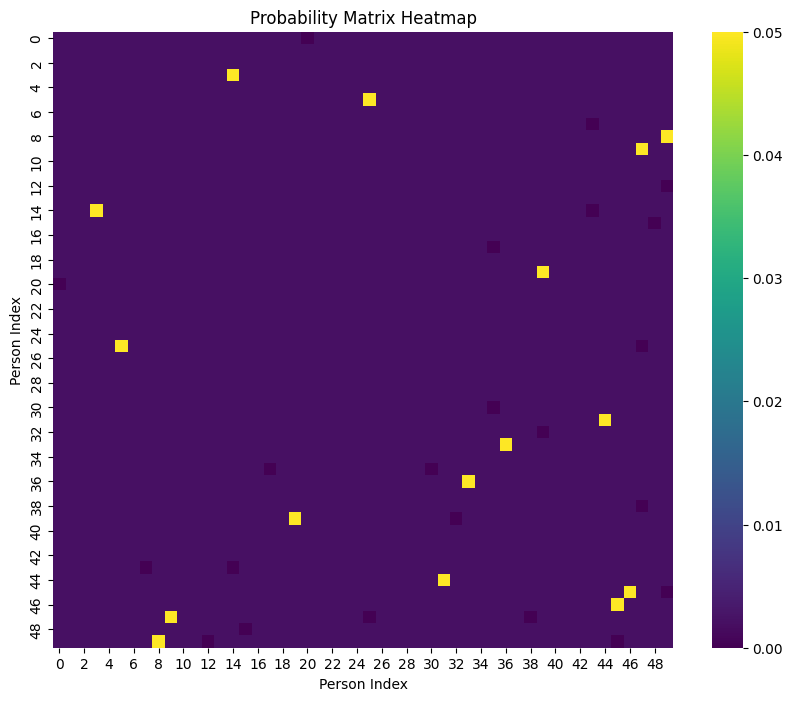

In [5]:
visualize_probability_matrix(probability_matrix[:50,:50])

In [8]:
import torch
import torch.nn.functional as F

# Calculate penalty based on the seating arrangement and probability matrix
def calculate_log_penalty(seating_probabilities, probability_matrix):
    penalty = 0
    batch_size = seating_probabilities.size(0)
    num_people = seating_probabilities.size(1)
    epsilon = 1e-9  # To avoid log(0)

    # Detach the probability matrix to prevent gradients from flowing through it
    probability_matrix = probability_matrix.detach()

    for i in range(batch_size):
        for j in range(num_people - 1):
            prob = seating_probabilities[i, j, j + 1]
            target_prob = probability_matrix[i, j, j + 1]
            # Penalize more for low probability matches
            penalty += -torch.log(prob + epsilon) * (1 / (target_prob + epsilon))
    return penalty / batch_size

# Custom loss function using raw logits
def custom_log_loss(logits, probability_matrix):
    seating_probabilities = F.softmax(logits, dim=-1)
    penalty = calculate_log_penalty(seating_probabilities, probability_matrix)
    return penalty

Epoch 0, Loss: 600527718.4
Epoch 1, Loss: 596696576.0
Epoch 2, Loss: 593352294.4
Epoch 3, Loss: 589495654.4
Epoch 4, Loss: 585413324.8
Epoch 5, Loss: 580950988.8
Epoch 6, Loss: 575117158.4
Epoch 7, Loss: 568645888.0
Epoch 8, Loss: 562138828.8
Epoch 9, Loss: 554774630.4
Epoch 10, Loss: 546679552.0
Epoch 11, Loss: 535649689.6
Epoch 12, Loss: 527263436.8
Epoch 13, Loss: 516590438.4
Epoch 14, Loss: 504501555.2
Epoch 15, Loss: 489425049.6
Epoch 16, Loss: 477942784.0
Epoch 17, Loss: 460009523.2
Epoch 18, Loss: 441694003.2
Epoch 19, Loss: 425485568.0
Epoch 20, Loss: 405710438.4
Epoch 21, Loss: 379077478.4
Epoch 22, Loss: 361042611.2
Epoch 23, Loss: 337836288.0
Epoch 24, Loss: 314363059.2
Epoch 25, Loss: 278707430.4
Epoch 26, Loss: 251908070.4
Epoch 27, Loss: 224419558.4
Epoch 28, Loss: 192504729.6
Epoch 29, Loss: 164385369.6
Epoch 30, Loss: 134056896.0
Epoch 31, Loss: 105104198.4
Epoch 32, Loss: 72043590.4
Epoch 33, Loss: 49753897.6
Epoch 34, Loss: 38148070.4
Epoch 35, Loss: 24009086.4
Epoch 

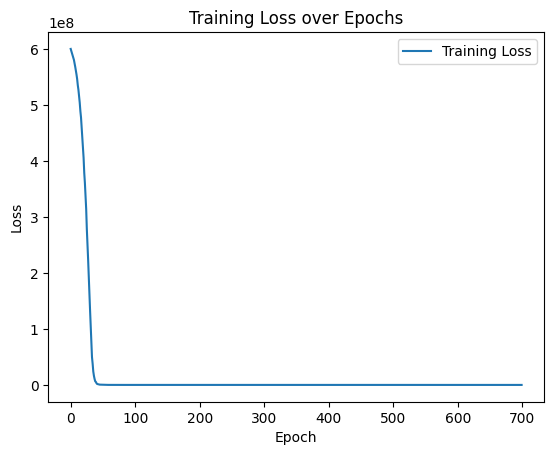

In [9]:
model = SeatingArrangementNet(num_people).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 700
batch_size = 20
losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # for i in range(0, len(probability_matrix), batch_size):
    batch_prob_matrix = probability_matrix.view(1, -1)
    batch_prob_matrix = batch_prob_matrix.repeat(batch_size, 1).to('cuda')

    optimizer.zero_grad()
    logits = model(batch_prob_matrix)
    loss = custom_log_loss(logits, batch_prob_matrix.view(batch_size, num_people, num_people))
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    avg_loss = total_loss / batch_size
    losses.append(avg_loss)
    print(f"Epoch {epoch}, Loss: {avg_loss}")

    # # Save the model every 10 epochs
    # if epoch % 10 == 0:
    #     torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")

# Plot the training loss
plt.figure()
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss over Epochs')
plt.show()


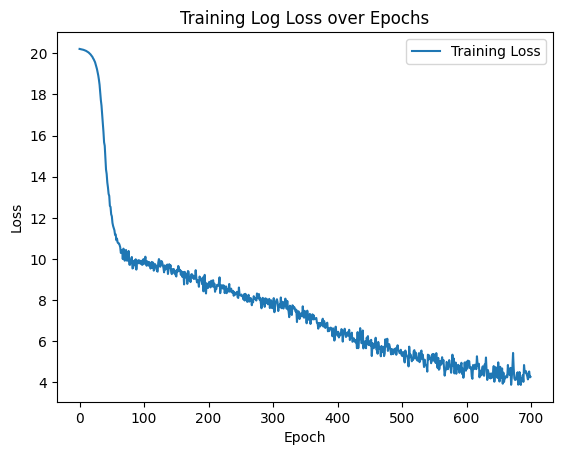

In [31]:
plt.figure()
plt.plot(np.log(losses), label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Log Loss over Epochs')
plt.show()

In [47]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def visualize_seating_arrangement(seating_arrangement, conflicts, group_members, num_people=400):
    seating_arrangement = seating_arrangement.reshape(20, 20)  # Reshape to 20x20
    # groups = np.arange(num_people) // 5  # Assuming each group has 5 people
    groups = np.zeros(400)
    for i, g in enumerate(group_members):
      for member in g:
        groups[member] = i
    # print(groups)

    # # Create a color map for groups
    # cmap = plt.cm.get_cmap('tab20', num_people // 5)
    # group_colors = cmap(groups)
    # print(group_colors)

    number_of_colors = num_people // 5
    cmap = plt.get_cmap('viridis')
    group_colors = [cmap(i) for i in np.linspace(0, 1, number_of_colors)]


    fig, ax = plt.subplots(figsize=(12, 12))

    # Create a color map for conflicts
    conflict_color_map = np.zeros((20, 20, 3))

    for i in range(20):
        for j in range(20):
            person = seating_arrangement[i, j]
            group_color = group_colors[int(groups[int(person)])]
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=group_color))
            ax.text(j + 0.5, i + 0.5, str(person), va='center', ha='center', fontsize=8, color='black')

            # Mark conflicts
            if i > 0 and ((seating_arrangement[i-1, j], person) in conflicts or (person, seating_arrangement[i-1, j]) in conflicts):  # Up
                conflict_color_map[i, j] = [1, 0, 0]  # Red for conflict
            if i < 19 and ((seating_arrangement[i+1, j], person) in conflicts or (person, seating_arrangement[i+1, j]) in conflicts):  # Down
                conflict_color_map[i, j] = [1, 0, 0]  # Red for conflict
            if j > 0 and ((seating_arrangement[i, j-1], person) in conflicts or (person, seating_arrangement[i, j-1]) in conflicts):  # Left
                conflict_color_map[i, j] = [1, 0, 0]  # Red for conflict
            if j < 19 and ((seating_arrangement[i, j+1], person) in conflicts or (person, seating_arrangement[i, j+1]) in conflicts):  # Right
                conflict_color_map[i, j] = [1, 0, 0]  # Red for conflict

    # Plot the conflict color map on top
    for i in range(20):
        for j in range(20):
            if np.any(conflict_color_map[i, j]):
                ax.add_patch(plt.Rectangle((j, i), 1, 1, color=conflict_color_map[i, j], alpha=0.5))

    ax.set_xticks(np.arange(20))
    ax.set_yticks(np.arange(20))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 20)
    ax.grid(which='both')
    plt.gca().invert_yaxis()
    plt.show()

# Example usage:
# Assuming `model_output` is the output logits from the model
# Generate a random seating arrangement for demonstration
# seating_arrangement = model(batch_prob_matrix).ar.numpy()

# # Generate a random conflict matrix
# conflict_matrix = np.zeros((400, 400))
# for _ in range(600):
#     i, j = np.random.choice(400, 2, replace=False)
#     if i // 5 != j // 5:  # Ensure conflicts are not within the same group
#         conflict_matrix[i, j] = conflict_matrix[j, i] = 1

# visualize_seating_arrangement(seating_arrangement, conflict_matrix)


In [51]:
output = model(batch_prob_matrix)[0]
seating_arrangement = output.argmax(dim=1).cpu().numpy()
seating_arrangement

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

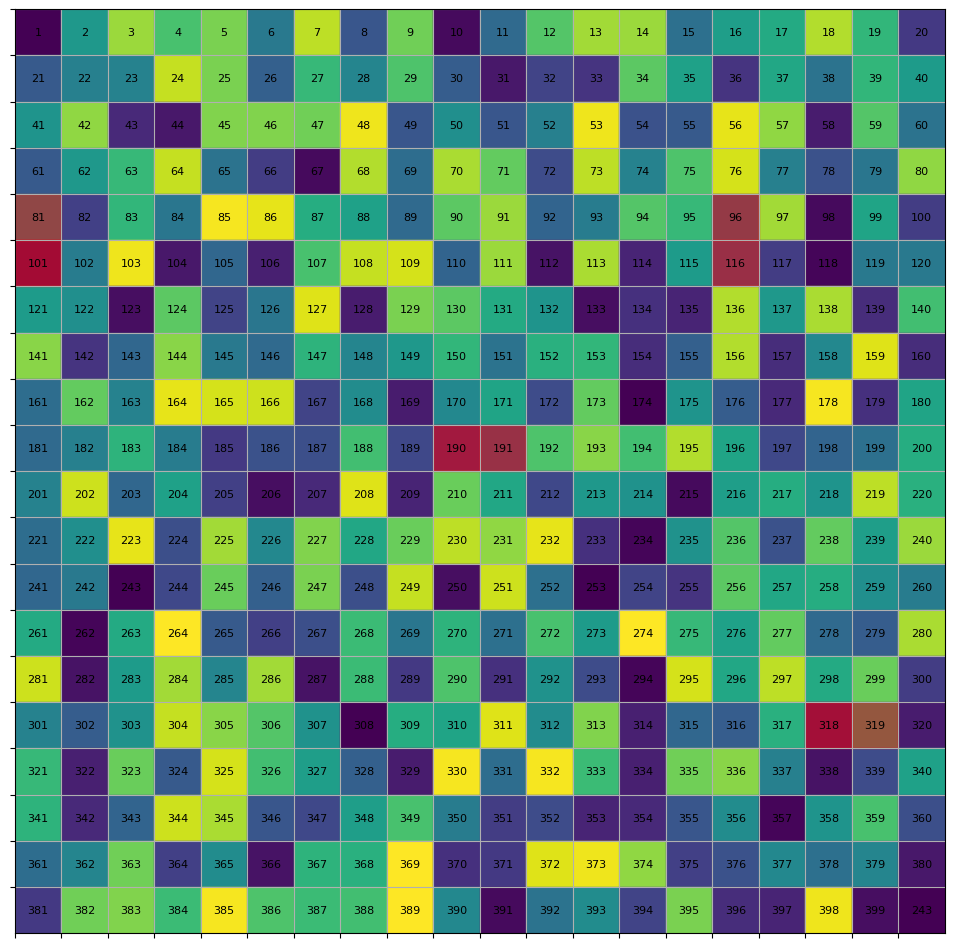

In [52]:
visualize_seating_arrangement(seating_arrangement, conflicts, groups, num_people=400)

## next try

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network model
class SeatingArrangementNet(nn.Module):
    def __init__(self, num_people):
        super(SeatingArrangementNet, self).__init__()
        self.num_people = num_people
        self.fc1 = nn.Linear(num_people * num_people, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_people * num_people)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.dropout(x, p=0.3, train=self.training)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, self.num_people, self.num_people)
        return x


# Generate the probability matrix based on alpha
def generate_probability_matrix(num_people, alpha, groups, conflicts):
    probability_matrix = np.ones((num_people, num_people)) * ((100 - alpha) / (num_people - 5))
    for group in groups:
        for j in group:
            for k in group:
                if j != k:
                    probability_matrix[j, k] = alpha / 4
    for i, j in conflicts:
        probability_matrix[i, j] = 0
        probability_matrix[j, i] = 0
    return probability_matrix

# Generate random groups and conflicts
def generate_groups_and_conflicts(num_people, num_groups, group_size, num_conflicts):
    groups = []
    all_people = np.arange(num_people)
    np.random.shuffle(all_people)
    for i in range(num_groups):
        group = all_people[i * group_size:(i + 1) * group_size].tolist()
        groups.append(group)

    conflicts = set()
    while len(conflicts) < num_conflicts:
        i, j = np.random.choice(num_people, 2, replace=False)
        if any(i in group and j in group for group in groups):
            continue
        conflicts.add((i, j))

    return groups, list(conflicts)



In [ ]:
import torch
import torch.nn.functional as F

# Calculate penalty based on the seating arrangement and probability matrix
def calculate_log_penalty(seating_probabilities, probability_matrix):
    penalty = 0
    batch_size = seating_probabilities.size(0)
    num_people = seating_probabilities.size(1)
    epsilon = 1e-9  # To avoid log(0)

    # Detach the probability matrix to prevent gradients from flowing through it
    probability_matrix = probability_matrix.detach()

    for i in range(batch_size):
        for j in range(num_people - 1):
            prob = seating_probabilities[i, j, j + 1]
            target_prob = probability_matrix[i, j, j + 1]
            # Penalize more for low probability matches
            penalty += -torch.log(prob + epsilon) *  (target_prob + epsilon)
    return penalty / batch_size

# Custom loss function using raw logits
def custom_log_loss(logits, probability_matrix):
    seating_probabilities = F.softmax(logits, dim=-1)
    penalty = calculate_log_penalty(seating_probabilities, probability_matrix)
    return penalty

In [ ]:
# Initialize the model, optimizer, and loss function
num_people = 400
num_groups = 80
group_size = 5
num_conflicts = 600
alpha = 0.2  # Adjust the importance of groups vs. conflicts

groups, conflicts = generate_groups_and_conflicts(num_people, num_groups, group_size, num_conflicts)
probability_matrix = generate_probability_matrix(num_people, alpha, groups, conflicts)
probability_matrix = torch.tensor(probability_matrix, dtype=torch.float32).to('cuda')

In [ ]:
model = SeatingArrangementNet(num_people).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 700
batch_size = 20
losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # for i in range(0, len(probability_matrix), batch_size):
    batch_prob_matrix = probability_matrix.view(1, -1)
    batch_prob_matrix = batch_prob_matrix.repeat(batch_size, 1).to('cuda')

    optimizer.zero_grad()
    logits = model(batch_prob_matrix)
    loss = custom_log_loss(logits, batch_prob_matrix.view(batch_size, num_people, num_people))
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    avg_loss = total_loss / batch_size
    losses.append(avg_loss)
    print(f"Epoch {epoch}, Loss: {avg_loss}")

    # # Save the model every 10 epochs
    # if epoch % 10 == 0:
    #     torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")

# Plot the training loss
plt.figure()
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss over Epochs')
plt.show()


#new approach

In [1]:
import torch.nn.functional as F

def compute_loss(P_hat, input_matrix, conflict_matrix):
    """
    Compute the loss for the given placement matrix and input matrix(combination of conflict matrix and groups matrix).

    Parameters:
    - P_hat: The predicted placement matrix (batch_size, 400, 400)
    - input_matrix: The conflict matrix (batch_size, 400, 400)

    Returns:
    - loss: The computed loss value
    """
    batch_size = P_hat.size(0)
    n = P_hat.size(1)  # This should be 400

    # Assignment loss
    row_sum_loss = F.mse_loss(torch.sum(P_hat, dim=2), torch.ones(batch_size, n, device=P_hat.device))
    col_sum_loss = F.mse_loss(torch.sum(P_hat, dim=1), torch.ones(batch_size, n, device=P_hat.device))
    assignment_loss = row_sum_loss + col_sum_loss

    # Conflict loss
    conflict_loss = 0
    conflict_matrix = conflict_matrix.detach()
    for b in range(batch_size):
        P = P_hat[b]
        P_t = P.transpose(0, 1)
        C = torch.matmul(torch.matmul(P, conflict_matrix[b].float()), P_t)

        for i in range(20):
            for j in range(20):
                current_index = i * 20 + j
                if j < 19:  # Right neighbor
                    right_index = i * 20 + (j + 1)
                    conflict_loss += C[current_index, right_index]
                if i < 19:  # Front neighbor
                    front_index = (i + 1) * 20 + j
                    conflict_loss += C[current_index, front_index]
                if j > 0:  # Left neighbor
                    left_index = i * 20 + (j - 1)
                    conflict_loss += C[current_index, left_index]
                if i > 0:  # Back neighbor
                    back_index = (i - 1) * 20 + j
                    conflict_loss += C[current_index, back_index]

    conflict_loss = conflict_loss / (batch_size * 4 * (n - 1))

    # Group loss
    group_loss = 0
    counts = P_hat.exp()
    probs = counts / counts.sum(1, keepdims=True)
    for b in range(batch_size):
        P = probs[b]
        for i in range(n):
            # get index of the maximum value as the seat of ith person
            seat = P[i].argmax()
            if seat == n - 1:
                continue
            group_loss += -P[input_matrix[b, i] == 1, seat + 1].log().sum()
            group_loss += P[input_matrix[b, i] == -1, seat + 1].log().sum()

    group_loss = group_loss / (batch_size * n)

    # Total loss
    total_loss = 100 * assignment_loss + conflict_loss + group_loss
    print(f"Total Loss: {total_loss.item()}, Assignment Loss: {assignment_loss.item()}, Conflict Loss: {conflict_loss.item()}, Group Loss: {group_loss.item()}")
    return total_loss


In [1]:
# Generate random groups and conflicts
def generate_groups_and_conflicts(num_people, num_groups, group_size, num_conflicts):
    groups = []
    all_people = np.arange(num_people)
    np.random.shuffle(all_people)
    for i in range(num_groups):
        group = all_people[i * group_size:(i + 1) * group_size].tolist()
        groups.append(group)

    conflicts = set()
    while len(conflicts) < num_conflicts:
        i, j = np.random.choice(num_people, 2, replace=False)
        if any(i in group and j in group for group in groups):
            continue
        conflicts.add((i, j))

    return groups, list(conflicts)

In [2]:
def generate_conflict_matrix(conflicts, num_people):
    conflict_matrix = np.zeros((num_people, num_people))
    for i, j in conflicts:
        conflict_matrix[i, j] = 1
        conflict_matrix[j, i] = 1
    return conflict_matrix

In [3]:
def generate_groups_matrix(groups, num_people):
    groups_matrix = np.zeros((num_people, num_people))
    for group in groups:
        for i in group:
            for j in group:
                groups_matrix[i, j] = 1
    return groups_matrix

In [4]:
def generate_input_matrix(groups_matrix, conflict_matrix, num_people):
    input_matrix = np.zeros((num_people, num_people))
    input_matrix[groups_matrix == 1] = 1
    input_matrix[conflict_matrix == 1] = -1
    return input_matrix

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network model
class SeatingArrangementNet(nn.Module):
    def __init__(self, num_people):
        super(SeatingArrangementNet, self).__init__()
        self.num_people = num_people
        self.fc1 = nn.Linear(num_people * num_people, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_people * num_people)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.dropout(x, p=0.3, train=self.training)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, self.num_people, self.num_people)
        return x

In [6]:
# Initialize the model, optimizer, and loss function
num_people = 400
num_groups = 80
group_size = 5
num_conflicts = 600
# alpha = 0.2  # Adjust the importance of groups vs. conflicts

groups, conflicts = generate_groups_and_conflicts(num_people, num_groups, group_size, num_conflicts)


In [7]:
groups_matrix = generate_groups_matrix(groups, num_people)
conflict_matrix = generate_conflict_matrix(conflicts, num_people)
input_matrix = generate_input_matrix(groups_matrix, conflict_matrix, num_people)
conflict_matrix = torch.tensor(conflict_matrix, dtype=torch.float32).to('cuda')
input_matrix = torch.tensor(input_matrix, dtype=torch.float32).to('cuda')

Total Loss: 305.5035400390625, Assignment Loss: 2.9355709552764893, Conflict Loss: 1.605982834007591e-05, Group Loss: 11.946412086486816
Epoch 0, Loss: 152.75177001953125
Total Loss: 229.98486328125, Assignment Loss: 2.180237293243408, Conflict Loss: 0.009987560100853443, Group Loss: 11.951138496398926
Epoch 1, Loss: 114.992431640625
Total Loss: 117.4663314819336, Assignment Loss: 1.054955005645752, Conflict Loss: 0.008500365540385246, Group Loss: 11.962332725524902
Epoch 2, Loss: 58.7331657409668
Total Loss: 82.26420593261719, Assignment Loss: 0.7038443088531494, Conflict Loss: 0.007102015428245068, Group Loss: 11.872676849365234
Epoch 3, Loss: 41.132102966308594
Total Loss: 63.87196731567383, Assignment Loss: 0.5192148685455322, Conflict Loss: 0.00502330856397748, Group Loss: 11.945457458496094
Epoch 4, Loss: 31.935983657836914
Total Loss: 56.7224235534668, Assignment Loss: 0.44778236746788025, Conflict Loss: 0.00687326118350029, Group Loss: 11.937313079833984
Epoch 5, Loss: 28.36121

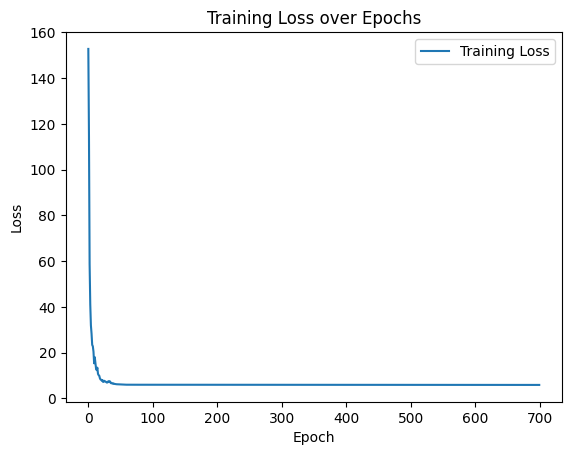

In [9]:
model = SeatingArrangementNet(num_people).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 700
batch_size = 2
losses = []
conflict_matrix = conflict_matrix.repeat(batch_size, 1).view(batch_size, num_people, num_people).to('cuda')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # for i in range(0, len(probability_matrix), batch_size):
    batch_input_matrix = input_matrix.view(1, -1)
    batch_input_matrix = batch_input_matrix.repeat(batch_size, 1).to('cuda')
    

    optimizer.zero_grad()
    logits = model(batch_input_matrix)
    loss = compute_loss(logits, batch_input_matrix.view(batch_size, num_people, num_people), conflict_matrix)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    avg_loss = total_loss / batch_size
    losses.append(avg_loss)
    print(f"Epoch {epoch}, Loss: {avg_loss}")

    # # Save the model every 10 epochs
    # if epoch % 10 == 0:
    #     torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")

# Plot the training loss
plt.figure()
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss over Epochs')
plt.show()

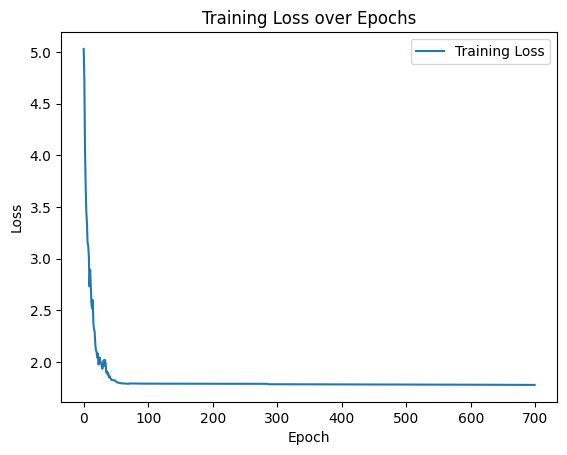

In [11]:
plt.figure()
plt.plot(np.log(losses), label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss over Epochs')
plt.show()

In [ ]:
# Generate example output from the model
model.eval()
with torch.no_grad():
    logits = model(input_matrix.view(1, -1).to('cuda'))
    seating_probabilities = F.softmax(logits, dim=-1)
    seating_arrangement = seating_probabilities.argmax(dim=-1).squeeze().tolist()

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_seating_arrangement(seating_arrangement, conflict_matrix, group_members, num_people=400):
    seating_arrangement = seating_arrangement.reshape(20, 20)  # Reshape to 20x20
    groups = np.zeros(num_people)
    
    # Assign group indices to each person
    for group_idx, group in enumerate(group_members):
        for member in group:
            groups[member] = group_idx

    # Create a color map for groups
    num_groups = len(group_members)
    cmap = plt.get_cmap('viridis', num_groups)
    group_colors = [cmap(i) for i in range(num_groups)]

    fig, ax = plt.subplots(figsize=(12, 12))

    for i in range(20):
        for j in range(20):
            person = seating_arrangement[i, j]
            group_color = group_colors[int(groups[person])]
            ax.add_patch(plt.Rectangle((j, i), 1, 1, color=group_color))
            ax.text(j + 0.5, i + 0.5, str(person.item()), va='center', ha='center', fontsize=8, color='black')

            # Mark conflicts with outlines
            if i > 0 and conflict_matrix[int(person.item()), int(seating_arrangement[i-1, j])] == 1:  # Up
                ax.plot([j, j+1], [i, i], color='red', linewidth=2)
            if i < 19 and conflict_matrix[int(person.item()), int(seating_arrangement[i+1, j])] == 1:  # Down
                ax.plot([j, j+1], [i+1, i+1], color='red', linewidth=2)
            if j > 0 and conflict_matrix[int(person.item()), int(seating_arrangement[i, j-1])] == 1:  # Left
                ax.plot([j, j], [i, i+1], color='red', linewidth=2)
            if j < 19 and conflict_matrix[int(person.item()), int(seating_arrangement[i, j+1])] == 1:  # Right
                ax.plot([j+1, j+1], [i, i+1], color='red', linewidth=2)

    ax.set_xticks(np.arange(20))
    ax.set_yticks(np.arange(20))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(0, 20)
    ax.set_ylim(0, 20)
    ax.grid(which='both')
    plt.gca().invert_yaxis()
    plt.show()

# Example usage:
# seating_arrangement = np.random.permutation(400)  # Example seating arrangement
# conflicts = np.zeros((2, 400, 400))  # Example conflict matrix
# group_members = [list(range(5 * i, 5 * (i + 1))) for i in range(80)]  # Example groups
# visualize_seating_arrangement(seating_arrangement, conflicts, group_members)


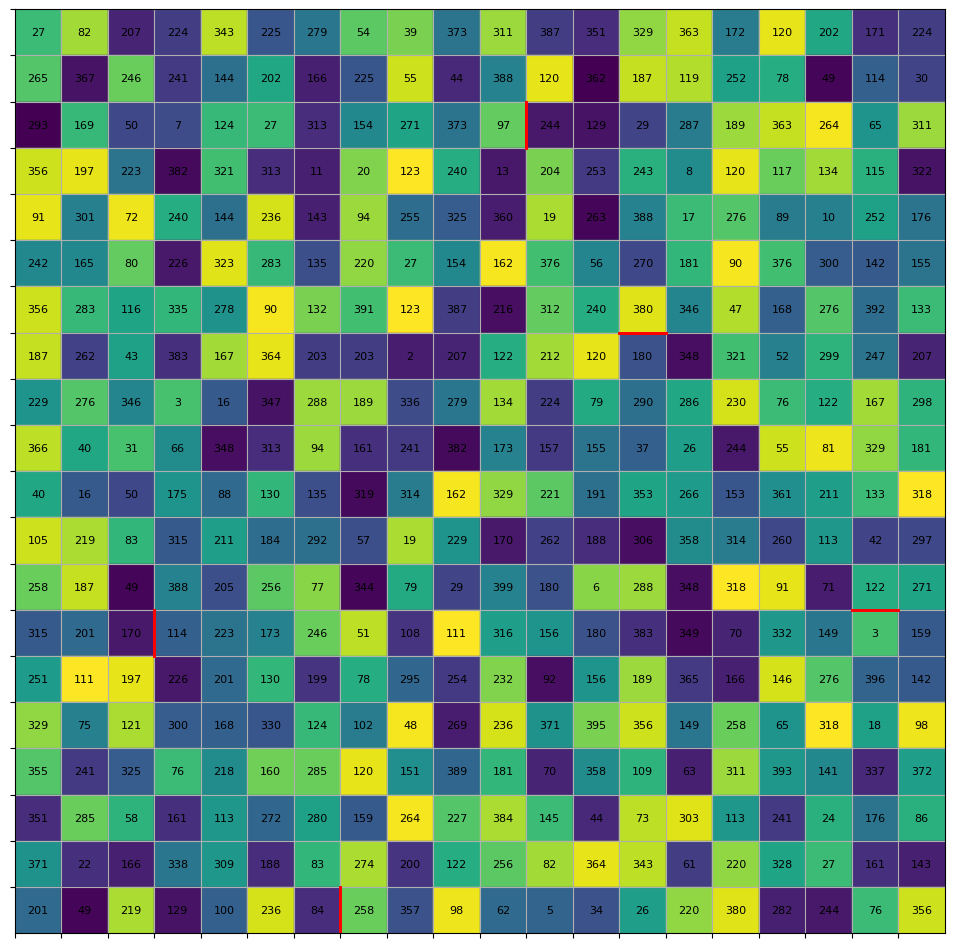

In [48]:
visualize_seating_arrangement(seating_probabilities.argmax(dim=-1).squeeze(), conflict_matrix, groups, num_people=400)

the last loss had a good performance on the conflicts but the groups are not considered . so we change the training setting a little bit and see if the result changes.

In [13]:
import torch
import torch.nn.functional as F

def compute_loss(P_hat, input_matrix, conflict_matrix):
    """
    Compute the loss for the given placement matrix and input matrix (combination of conflict matrix and groups matrix).

    Parameters:
    - P_hat: The predicted placement matrix (batch_size, 400, 400)
    - input_matrix: The conflict matrix (batch_size, 400, 400)

    Returns:
    - loss: The computed loss value
    """
    batch_size = P_hat.size(0)
    n = P_hat.size(1)  # This should be 400

    # Assignment loss
    row_sum_loss = F.mse_loss(torch.sum(P_hat, dim=2), torch.ones(batch_size, n, device=P_hat.device))
    col_sum_loss = F.mse_loss(torch.sum(P_hat, dim=1), torch.ones(batch_size, n, device=P_hat.device))
    assignment_loss = row_sum_loss + col_sum_loss

    # Conflict loss
    conflict_loss = 0
    conflict_matrix = conflict_matrix.detach()
    for b in range(batch_size):
        P = P_hat[b]
        P_t = P.transpose(0, 1)
        C = torch.matmul(torch.matmul(P, conflict_matrix[b].float()), P_t)

        for i in range(20):
            for j in range(20):
                current_index = i * 20 + j
                if j < 19:  # Right neighbor
                    right_index = i * 20 + (j + 1)
                    conflict_loss += C[current_index, right_index]
                if i < 19:  # Front neighbor
                    front_index = (i + 1) * 20 + j
                    conflict_loss += C[current_index, front_index]
                if j > 0:  # Left neighbor
                    left_index = i * 20 + (j - 1)
                    conflict_loss += C[current_index, left_index]
                if i > 0:  # Back neighbor
                    back_index = (i - 1) * 20 + j
                    conflict_loss += C[current_index, back_index]

    # Normalize conflict loss
    conflict_loss /= (batch_size * 20 * 20)

    # Group loss
    group_loss = 0
    counts = P_hat.exp()
    probs = counts / counts.sum(1, keepdims=True)
    for b in range(batch_size):
        P = probs[b]
        for i in range(400):
            seat = P[i].argmax()
            if seat == 399:
                continue
            group_probs = P[input_matrix[b, i] == 1, seat + 1]
            conflict_probs = P[input_matrix[b, i] == -1, seat + 1]

            # Ensure no zero probabilities
            group_probs = torch.clamp(group_probs, min=1e-9)
            conflict_probs = torch.clamp(conflict_probs, min=1e-9)

            group_loss += -group_probs.log().sum()
            group_loss += conflict_probs.log().sum()

    # Normalize group loss
    group_loss /= (batch_size * 400)

    # Total loss
    total_loss = 100 * assignment_loss + conflict_loss + group_loss
    print("total_loss:", total_loss.item(), " assignment_loss: ", assignment_loss.item(), "conflict_loss: ", conflict_loss.item(), "group_loss: ", group_loss.item())
    return total_loss


In [11]:
groups_matrix = generate_groups_matrix(groups, num_people)
conflict_matrix = generate_conflict_matrix(conflicts, num_people)
input_matrix = generate_input_matrix(groups_matrix, conflict_matrix, num_people)
conflict_matrix = torch.tensor(conflict_matrix, dtype=torch.float32).to('cuda')
input_matrix = torch.tensor(input_matrix, dtype=torch.float32).to('cuda')

total_loss: 278.6095886230469  assignment_loss:  2.666247844696045 conflict_loss:  -0.0015027120243757963 group_loss:  11.986298561096191
Epoch 0, Loss: 278.6095886230469
total_loss: 1058781.125  assignment_loss:  10586.1640625 conflict_loss:  152.4605255126953 group_loss:  12.197842597961426
Epoch 1, Loss: 1058781.125
total_loss: 6806.2236328125  assignment_loss:  67.93468475341797 conflict_loss:  0.7097927927970886 group_loss:  12.045516014099121
Epoch 2, Loss: 6806.2236328125
total_loss: 83868.6796875  assignment_loss:  838.460205078125 conflict_loss:  10.626017570495605 group_loss:  12.029946327209473
Epoch 3, Loss: 83868.6796875
total_loss: 11693.4541015625  assignment_loss:  116.80015563964844 conflict_loss:  1.3408476114273071 group_loss:  12.09798812866211
Epoch 4, Loss: 11693.4541015625
total_loss: 59951.25  assignment_loss:  599.3012084960938 conflict_loss:  9.059147834777832 group_loss:  12.070871353149414
Epoch 5, Loss: 59951.25
total_loss: 43088.33203125  assignment_loss: 

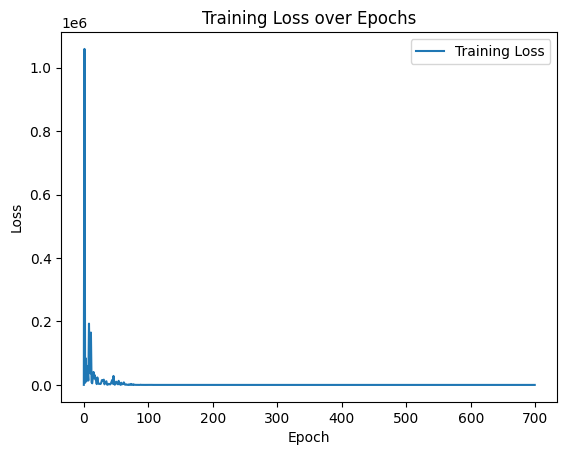

In [14]:
model = SeatingArrangementNet(num_people).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 700
batch_size = 2
losses = []
# conflict_matrix = conflict_matrix.repeat(batch_size, 1).view(batch_size, num_people, num_people).to('cuda')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # for i in range(0, len(probability_matrix), batch_size):
    batch_input_matrix = input_matrix.view(1, -1)
    batch_input_matrix = batch_input_matrix.repeat(batch_size, 1).to('cuda')
    

    optimizer.zero_grad()
    logits = model(batch_input_matrix)
    loss = compute_loss(logits, batch_input_matrix.view(batch_size, num_people, num_people), conflict_matrix)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    avg_loss = total_loss
    losses.append(avg_loss)
    print(f"Epoch {epoch}, Loss: {avg_loss}")

    # # Save the model every 10 epochs
    # if epoch % 10 == 0:
    #     torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")

# Plot the training loss
plt.figure()
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss over Epochs')
plt.show()

In [15]:
# Generate example output from the model
model.eval()
with torch.no_grad():
    logits = model(input_matrix.view(1, -1).to('cuda'))
    seating_probabilities = F.softmax(logits, dim=-1)
    seating_arrangement = seating_probabilities.argmax(dim=-1).squeeze()

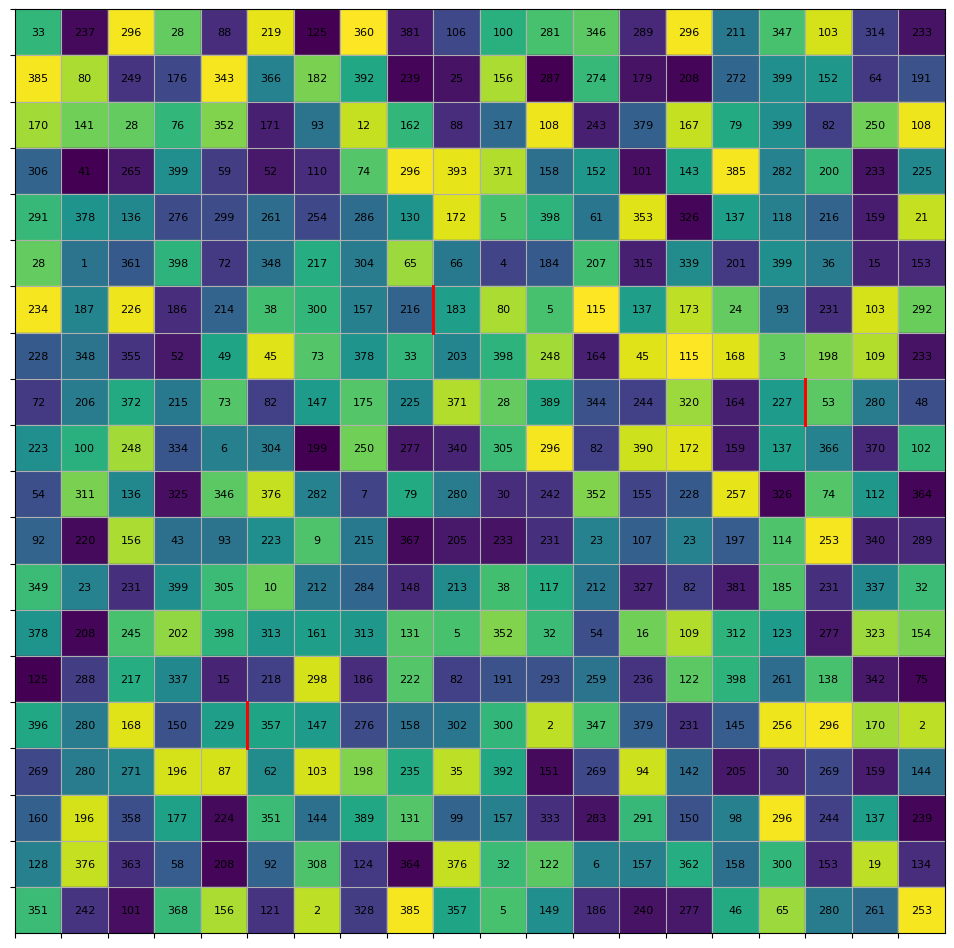

In [16]:
visualize_seating_arrangement(seating_arrangement, conflict_matrix, groups, num_people=400)

In [9]:
import torch
import torch.nn.functional as F

def compute_loss(P_hat, input_matrix, conflict_matrix, assignment_weight=1.0, conflict_weight=1.0, group_weight=1.0):
    """
    Compute the loss for the given placement matrix and input matrix (combination of conflict matrix and groups matrix).

    Parameters:
    - P_hat: The predicted placement matrix (batch_size, 400, 400)
    - input_matrix: The conflict matrix (batch_size, 400, 400)
    - assignment_weight: Weight for the assignment loss
    - conflict_weight: Weight for the conflict loss
    - group_weight: Weight for the group loss

    Returns:
    - loss: The computed loss value
    """
    batch_size = P_hat.size(0)
    n = P_hat.size(1)  # This should be 400

    # Assignment loss
    row_sum_loss = F.mse_loss(torch.sum(P_hat, dim=2), torch.ones(batch_size, n, device=P_hat.device))
    col_sum_loss = F.mse_loss(torch.sum(P_hat, dim=1), torch.ones(batch_size, n, device=P_hat.device))
    assignment_loss = row_sum_loss + col_sum_loss

    # Conflict loss
    conflict_loss = 0
    conflict_matrix = conflict_matrix.detach()
    for b in range(batch_size):
        P = P_hat[b]
        P_t = P.transpose(0, 1)
        C = torch.matmul(torch.matmul(P, conflict_matrix[b].float()), P_t)

        for i in range(20):
            for j in range(20):
                current_index = i * 20 + j
                if j < 19:  # Right neighbor
                    right_index = i * 20 + (j + 1)
                    conflict_loss += C[current_index, right_index]
                if i < 19:  # Front neighbor
                    front_index = (i + 1) * 20 + j
                    conflict_loss += C[current_index, front_index]
                if j > 0:  # Left neighbor
                    left_index = i * 20 + (j - 1)
                    conflict_loss += C[current_index, left_index]
                if i > 0:  # Back neighbor
                    back_index = (i - 1) * 20 + j
                    conflict_loss += C[current_index, back_index]

    # Normalize conflict loss
    conflict_loss /= (batch_size * 20 * 20)

    # Group loss
    group_loss = 0
    counts = P_hat.exp()
    probs = counts / counts.sum(1, keepdims=True)
    for b in range(batch_size):
        P = probs[b]
        for i in range(400):
            seat = P[i].argmax()
            if seat == 399:
                continue
            group_probs = P[input_matrix[b, i] == 1, seat + 1]
            conflict_probs = P[input_matrix[b, i] == -1, seat + 1]

            # Ensure no zero probabilities
            group_probs = torch.clamp(group_probs, min=1e-9)
            conflict_probs = torch.clamp(conflict_probs, min=1e-9)

            group_loss += -group_probs.log().sum()
            group_loss += conflict_probs.log().sum()

    # Normalize group loss
    group_loss /= (batch_size * 400)

    # Total loss with weights
    total_loss = (assignment_weight * assignment_loss) + (conflict_weight * conflict_loss) + (group_weight * group_loss)
    print("total_loss:", total_loss.item(), " assignment_loss: ", assignment_loss.item(), "conflict_loss: ", conflict_loss.item(), "group_loss: ", group_loss.item())
    return total_loss


In [9]:
groups_matrix = generate_groups_matrix(groups, num_people)
conflict_matrix = generate_conflict_matrix(conflicts, num_people)
input_matrix = generate_input_matrix(groups_matrix, conflict_matrix, num_people)
conflict_matrix = torch.tensor(conflict_matrix, dtype=torch.float32).to('cuda')
input_matrix = torch.tensor(input_matrix, dtype=torch.float32).to('cuda')

total_loss: 388.8605651855469  assignment_loss:  2.6995344161987305 conflict_loss:  0.0006340830586850643 group_loss:  11.890079498291016
Epoch 0, Loss: 388.8605651855469
total_loss: 1438734.75  assignment_loss:  14365.265625 conflict_loss:  208.67848205566406 group_loss:  12.151418685913086
Epoch 1, Loss: 1438734.75
total_loss: 2299.676513671875  assignment_loss:  21.786970138549805 conflict_loss:  0.11787616461515427 group_loss:  11.980072021484375
Epoch 2, Loss: 2299.676513671875
total_loss: 9186.8486328125  assignment_loss:  90.58840942382812 conflict_loss:  0.820652186870575 group_loss:  11.980195999145508
Epoch 3, Loss: 9186.8486328125
total_loss: 5789.0869140625  assignment_loss:  56.65464782714844 conflict_loss:  0.38945576548576355 group_loss:  11.972757339477539
Epoch 4, Loss: 5789.0869140625
total_loss: 21469.072265625  assignment_loss:  213.16773986816406 conflict_loss:  3.264606237411499 group_loss:  11.965188026428223
Epoch 5, Loss: 21469.072265625
total_loss: 3328.552001

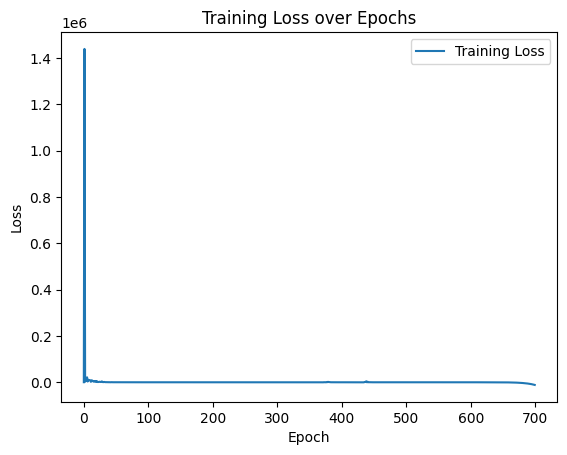

In [10]:
model = SeatingArrangementNet(num_people).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 700
batch_size = 10
losses = []
conflict_matrix_batch = conflict_matrix.repeat(batch_size, 1).view(batch_size, num_people, num_people).to('cuda')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # for i in range(0, len(probability_matrix), batch_size):
    batch_input_matrix = input_matrix.view(1, -1)
    batch_input_matrix = batch_input_matrix.repeat(batch_size, 1).to('cuda')
    

    optimizer.zero_grad()
    logits = model(batch_input_matrix)
    loss = compute_loss(logits, batch_input_matrix.view(batch_size, num_people, num_people), conflict_matrix_batch, assignment_weight=100, conflict_weight=10, group_weight=10)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    avg_loss = total_loss
    losses.append(avg_loss)
    print(f"Epoch {epoch}, Loss: {avg_loss}")

    # # Save the model every 10 epochs
    # if epoch % 10 == 0:
    #     torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")

# Plot the training loss
plt.figure()
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss over Epochs')
plt.show()

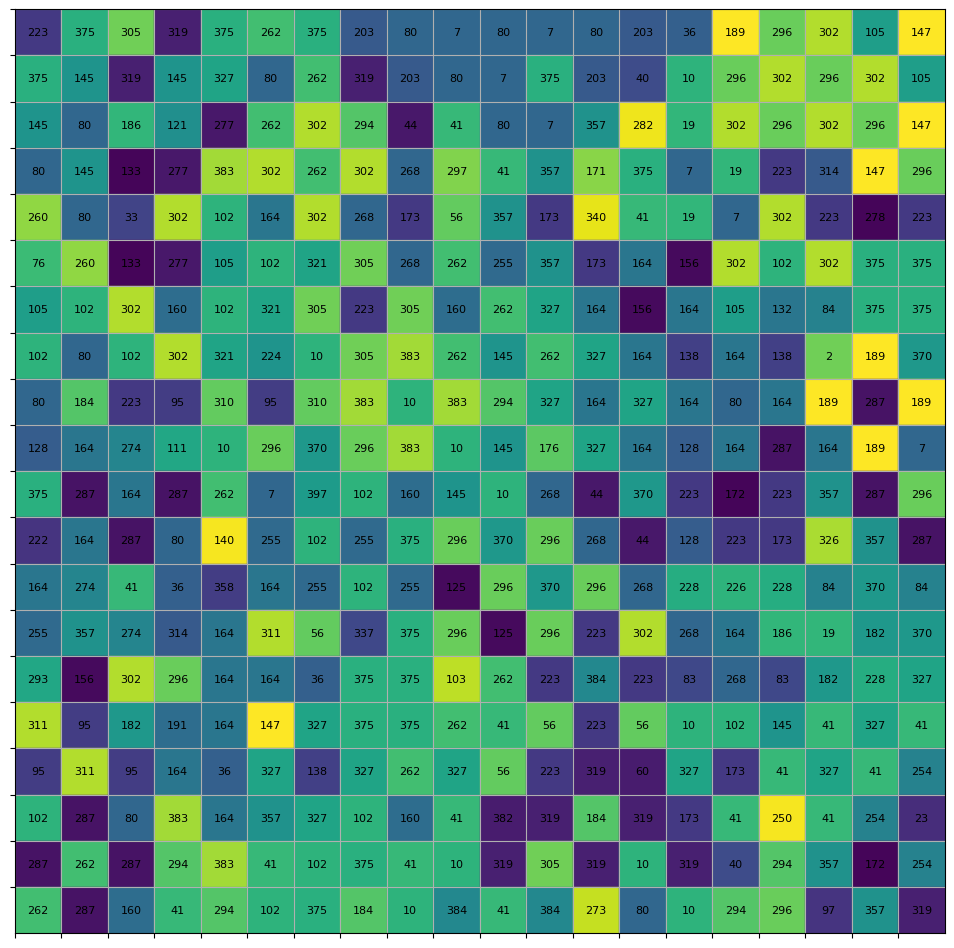

In [15]:
# Generate example output from the model
model.eval()
with torch.no_grad():
    logits = model(input_matrix.view(1, -1).to('cuda'))
    seating_probabilities = F.softmax(logits, dim=-1)
    seating_arrangement = seating_probabilities.argmax(dim=-1).squeeze()

visualize_seating_arrangement(seating_arrangement, conflict_matrix, groups, num_people=400)

In [16]:
# continue training

for epoch in range(num_epochs, num_epochs+100):
    model.train()
    total_loss = 0

    # for i in range(0, len(probability_matrix), batch_size):
    batch_input_matrix = input_matrix.view(1, -1)
    batch_input_matrix = batch_input_matrix.repeat(batch_size, 1).to('cuda')
    

    optimizer.zero_grad()
    logits = model(batch_input_matrix)
    loss = compute_loss(logits, batch_input_matrix.view(batch_size, num_people, num_people), conflict_matrix_batch, assignment_weight=100, conflict_weight=10, group_weight=10)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    avg_loss = total_loss
    losses.append(avg_loss)
    print(f"Epoch {epoch}, Loss: {avg_loss}")

total_loss: -12105.4912109375  assignment_loss:  0.011713151820003986 conflict_loss:  -1220.9808349609375 group_loss:  10.314651489257812
Epoch 700, Loss: -12105.4912109375
total_loss: -12960.7099609375  assignment_loss:  0.0015062669990584254 conflict_loss:  -1306.404052734375 group_loss:  10.318056106567383
Epoch 701, Loss: -12960.7099609375
total_loss: -13874.73828125  assignment_loss:  0.00430274149402976 conflict_loss:  -1397.8492431640625 group_loss:  10.332326889038086
Epoch 702, Loss: -13874.73828125
total_loss: -14853.130859375  assignment_loss:  0.012734157964587212 conflict_loss:  -1495.7381591796875 group_loss:  10.297704696655273
Epoch 703, Loss: -14853.130859375
total_loss: -15899.94921875  assignment_loss:  0.007531522307544947 conflict_loss:  -1600.375244140625 group_loss:  10.305004119873047
Epoch 704, Loss: -15899.94921875
total_loss: -17020.619140625  assignment_loss:  0.002875866834074259 conflict_loss:  -1712.39453125 group_loss:  10.303924560546875
Epoch 705, Loss

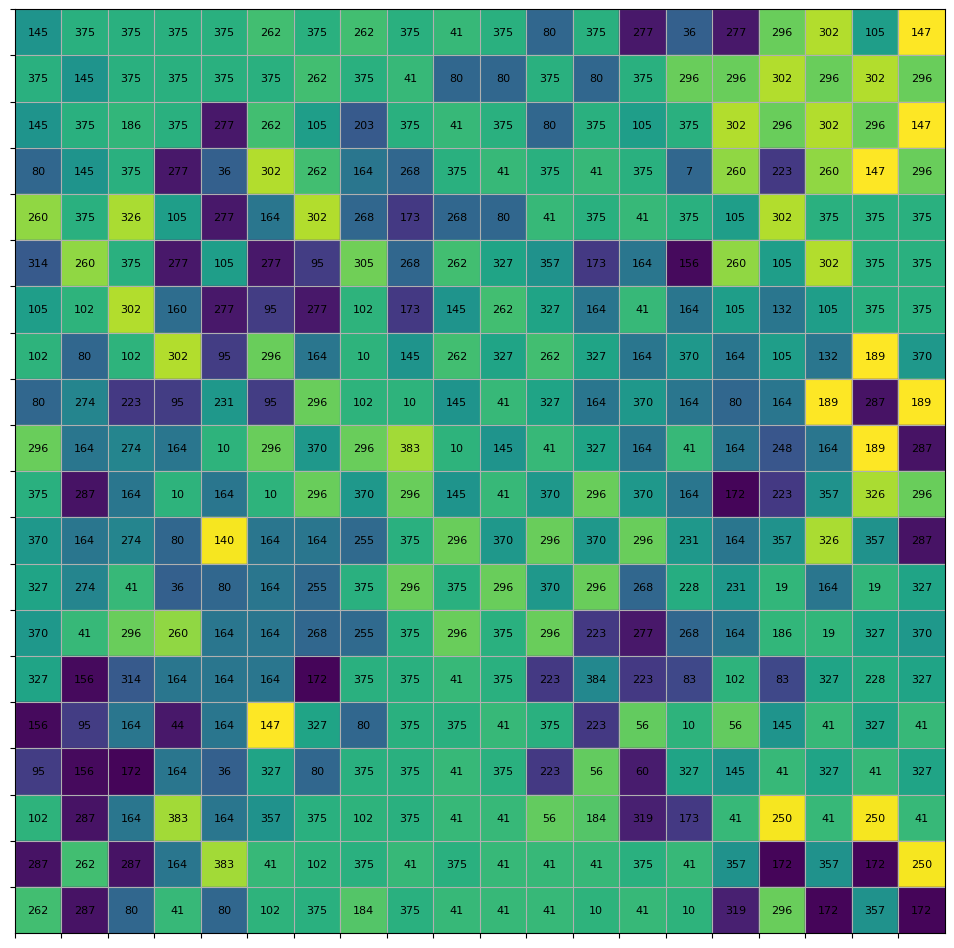

In [17]:
# Generate example output from the model
model.eval()
with torch.no_grad():
    logits = model(input_matrix.view(1, -1).to('cuda'))
    seating_probabilities = F.softmax(logits, dim=-1)
    seating_arrangement = seating_probabilities.argmax(dim=-1).squeeze()

visualize_seating_arrangement(seating_arrangement, conflict_matrix, groups, num_people=400)

softmax is not applied on the logits and it may be the cause of repetition in assignments. so before changing the loss function first we try softmax.

In [18]:


import torch
import torch.nn.functional as F

def compute_loss(P_hat, input_matrix, conflict_matrix, assignment_weight=1.0, conflict_weight=1.0, group_weight=1.0):
    """
    Compute the loss for the given placement matrix and input matrix (combination of conflict matrix and groups matrix).

    Parameters:
    - P_hat: The predicted placement matrix (batch_size, 400, 400)
    - input_matrix: The conflict matrix (batch_size, 400, 400)
    - assignment_weight: Weight for the assignment loss
    - conflict_weight: Weight for the conflict loss
    - group_weight: Weight for the group loss

    Returns:
    - loss: The computed loss value
    """
    batch_size = P_hat.size(0)
    n = P_hat.size(1)  # This should be 400
    P_hat = F.softmax(P_hat, dim=-1)

    # Assignment loss
    row_sum_loss = F.mse_loss(torch.sum(P_hat, dim=2), torch.ones(batch_size, n, device=P_hat.device))
    col_sum_loss = F.mse_loss(torch.sum(P_hat, dim=1), torch.ones(batch_size, n, device=P_hat.device))
    assignment_loss = row_sum_loss + col_sum_loss

    # Conflict loss
    conflict_loss = 0
    conflict_matrix = conflict_matrix.detach()
    for b in range(batch_size):
        P = P_hat[b]
        P_t = P.transpose(0, 1)
        C = torch.matmul(torch.matmul(P, conflict_matrix[b].float()), P_t)

        for i in range(20):
            for j in range(20):
                current_index = i * 20 + j
                if j < 19:  # Right neighbor
                    right_index = i * 20 + (j + 1)
                    conflict_loss += C[current_index, right_index]
                if i < 19:  # Front neighbor
                    front_index = (i + 1) * 20 + j
                    conflict_loss += C[current_index, front_index]
                if j > 0:  # Left neighbor
                    left_index = i * 20 + (j - 1)
                    conflict_loss += C[current_index, left_index]
                if i > 0:  # Back neighbor
                    back_index = (i - 1) * 20 + j
                    conflict_loss += C[current_index, back_index]

    # Normalize conflict loss
    conflict_loss /= (batch_size * 20 * 20)

    # Group loss
    group_loss = 0
    # counts = P_hat.exp()
    # probs = counts / counts.sum(1, keepdims=True)
    probs = P_hat
    for b in range(batch_size):
        P = probs[b]
        for i in range(400):
            seat = P[i].argmax()
            if seat == 399:
                continue
            group_probs = P[input_matrix[b, i] == 1, seat + 1]
            conflict_probs = P[input_matrix[b, i] == -1, seat + 1]

            # Ensure no zero probabilities
            group_probs = torch.clamp(group_probs, min=1e-9)
            conflict_probs = torch.clamp(conflict_probs, min=1e-9)

            group_loss += -group_probs.log().sum()
            group_loss += conflict_probs.log().sum()

    # Normalize group loss
    group_loss /= (batch_size * 400)

    # Total loss with weights
    total_loss = (assignment_weight * assignment_loss) + (conflict_weight * conflict_loss) + (group_weight * group_loss)
    print("total_loss:", total_loss.item(), " assignment_loss: ", assignment_loss.item(), "conflict_loss: ", conflict_loss.item(), "group_loss: ", group_loss.item())
    return total_loss

In [19]:
model = SeatingArrangementNet(num_people).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 700
batch_size = 10
losses = []
conflict_matrix_batch = conflict_matrix.repeat(batch_size, 1).view(batch_size, num_people, num_people).to('cuda')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # for i in range(0, len(probability_matrix), batch_size):
    batch_input_matrix = input_matrix.view(1, -1)
    batch_input_matrix = batch_input_matrix.repeat(batch_size, 1).to('cuda')
    

    optimizer.zero_grad()
    logits = model(batch_input_matrix)
    loss = compute_loss(logits, batch_input_matrix.view(batch_size, num_people, num_people), conflict_matrix_batch, assignment_weight=100, conflict_weight=10, group_weight=1)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    avg_loss = total_loss
    losses.append(avg_loss)
    print(f"Epoch {epoch}, Loss: {avg_loss}")

    # # Save the model every 10 epochs
    # if epoch % 10 == 0:
    #     torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")

# Plot the training loss
plt.figure()
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss over Epochs')
plt.show()

total_loss: 120.0597152709961  assignment_loss:  2.394414195805439e-06 conflict_loss:  0.028499174863100052 group_loss:  11.977448463439941
Epoch 0, Loss: 120.0597152709961
total_loss: 122.79023742675781  assignment_loss:  0.0019162932876497507 conflict_loss:  0.028151892125606537 group_loss:  12.231709480285645
Epoch 1, Loss: 122.79023742675781
total_loss: 114.01875305175781  assignment_loss:  0.0007454458391293883 conflict_loss:  0.028365589678287506 group_loss:  11.366055488586426
Epoch 2, Loss: 114.01875305175781
total_loss: 104.97368621826172  assignment_loss:  0.002198019064962864 conflict_loss:  0.028368348255753517 group_loss:  10.447019577026367
Epoch 3, Loss: 104.97368621826172
total_loss: 80.00167846679688  assignment_loss:  0.014319060370326042 conflict_loss:  0.02807687036693096 group_loss:  7.828900337219238
Epoch 4, Loss: 80.00167846679688
total_loss: 51.99093246459961  assignment_loss:  0.08799605816602707 conflict_loss:  0.02722528763115406 group_loss:  4.2919073104858

KeyboardInterrupt: 

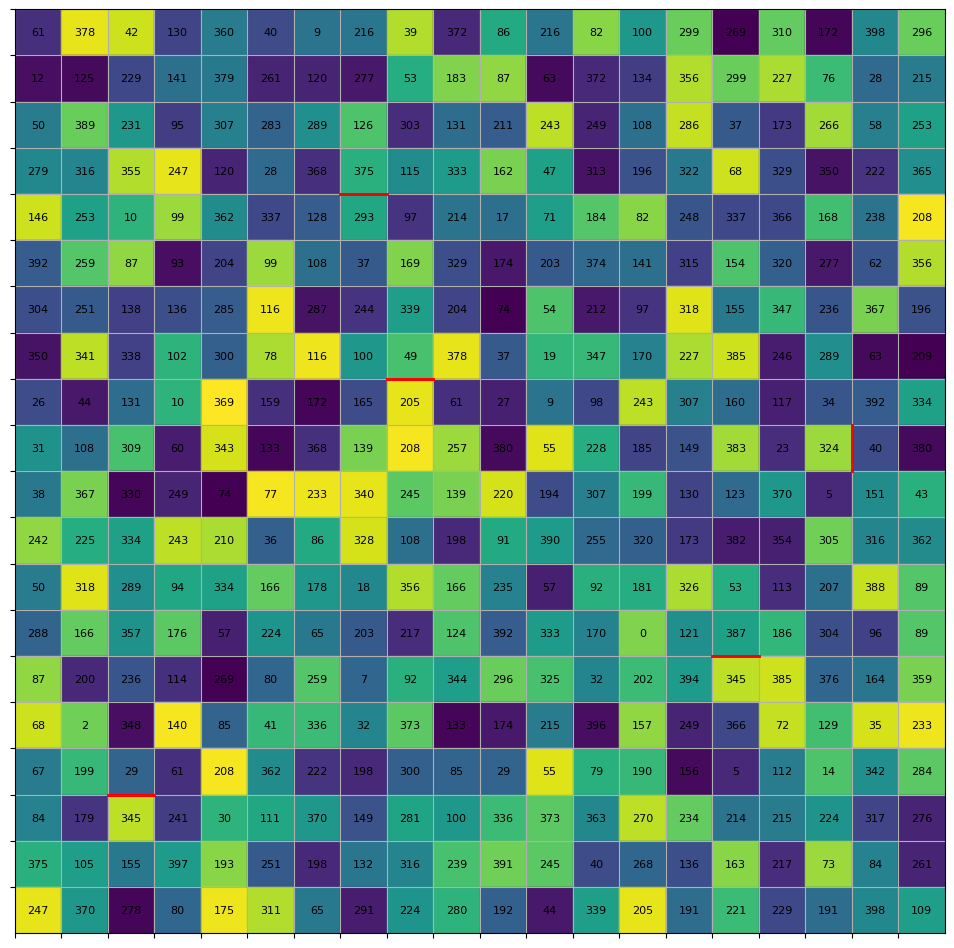

In [23]:
#  Generate example output from the model
model.eval()
with torch.no_grad():
    logits = model(input_matrix.view(1, -1).to('cuda'))
    seating_probabilities = F.softmax(logits, dim=-1)
    seating_arrangement = seating_probabilities.argmax(dim=-1).squeeze()

visualize_seating_arrangement(seating_arrangement, conflict_matrix, groups, num_people=400)

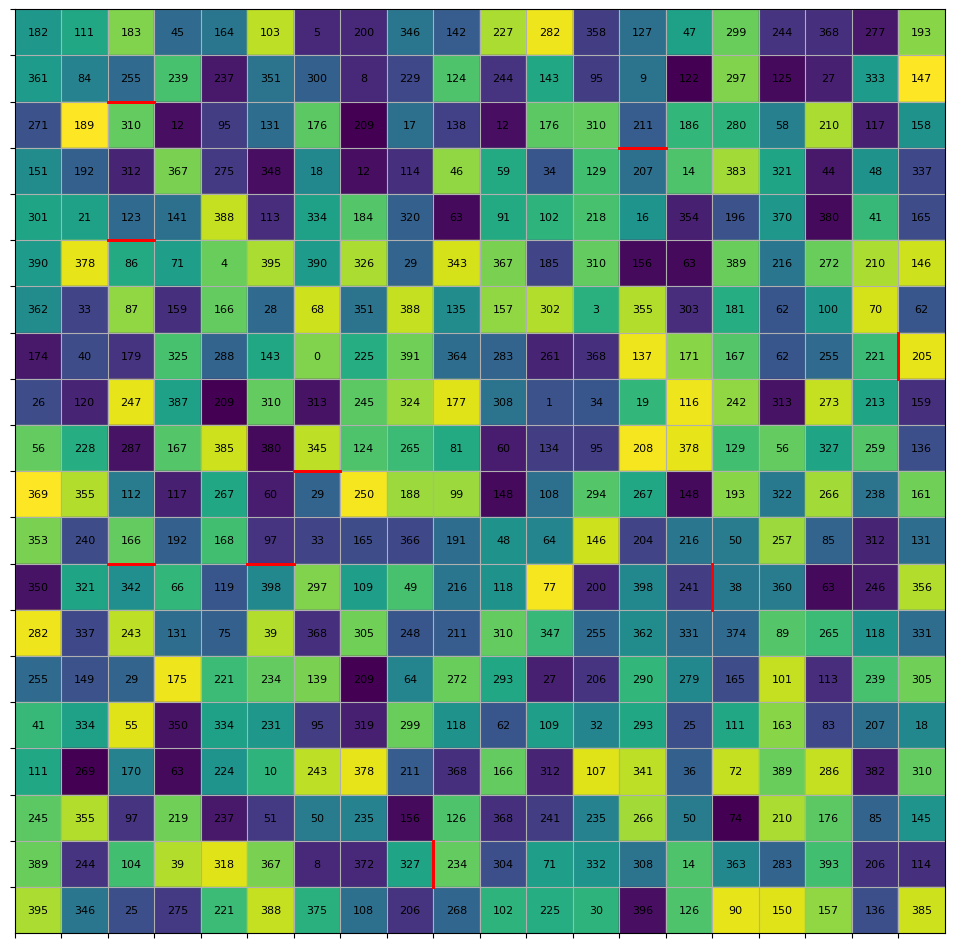

In [22]:
model_untrained = SeatingArrangementNet(num_people).to('cuda')
#  Generate example output from the model
model_untrained.eval()
with torch.no_grad():
    logits = model_untrained(input_matrix.view(1, -1).to('cuda'))
    seating_probabilities = F.softmax(logits, dim=-1)
    seating_arrangement = seating_probabilities.argmax(dim=-1).squeeze()

visualize_seating_arrangement(seating_arrangement, conflict_matrix, groups, num_people=400)

In [10]:
import torch
import torch.nn.functional as F

def compute_loss(P_hat, input_matrix, conflict_matrix, assignment_weight=1.0, conflict_weight=1.0, group_weight=1.0):
    """
    Compute the loss for the given placement matrix and input matrix (combination of conflict matrix and groups matrix).

    Parameters:
    - P_hat: The predicted placement matrix (batch_size, 400, 400)
    - input_matrix: The conflict matrix (batch_size, 400, 400)
    - assignment_weight: Weight for the assignment loss
    - conflict_weight: Weight for the conflict loss
    - group_weight: Weight for the group loss

    Returns:
    - loss: The computed loss value
    """
    batch_size = P_hat.size(0)
    n = P_hat.size(1)  # This should be 400

     # Apply softmax to logits to get probabilities
    P = torch.softmax(P_hat, dim=2)

    # Assignment loss
    row_sum_loss = F.mse_loss(torch.sum(P, dim=2), torch.ones(batch_size, n, device=P.device))
    col_sum_loss = F.mse_loss(torch.sum(P, dim=1), torch.ones(batch_size, n, device=P.device))
    assignment_loss = row_sum_loss + col_sum_loss

    # Conflict loss
    conflict_loss = 0
    conflict_matrix = conflict_matrix.detach()
    for b in range(batch_size):
        P_batch = P[b]
        P_t = P_batch.transpose(0, 1)
        C = torch.matmul(torch.matmul(P_batch, conflict_matrix[b].float()), P_t)

        for i in range(20):
            for j in range(20):
                current_index = i * 20 + j
                if j < 19:  # Right neighbor
                    right_index = i * 20 + (j + 1)
                    conflict_loss += C[current_index, right_index]
                if i < 19:  # Front neighbor
                    front_index = (i + 1) * 20 + j
                    conflict_loss += C[current_index, front_index]
                if j > 0:  # Left neighbor
                    left_index = i * 20 + (j - 1)
                    conflict_loss += C[current_index, left_index]
                if i > 0:  # Back neighbor
                    back_index = (i - 1) * 20 + j
                    conflict_loss += C[current_index, back_index]

    # Normalize conflict loss
    conflict_loss /= (batch_size)

    # Group loss
    group_loss = 0
    counts = P_hat.exp()
    probs = counts / counts.sum(1, keepdims=True)
    for b in range(batch_size):
        # P = probs[b]
        # for i in range(400):
        #     for j in range(399):
        #         seat = j

        #         group_probs = P[input_matrix[b, i] == 1, seat + 1]
        #         conflict_probs = P[input_matrix[b, i] == -1, seat + 1]

        #         # Ensure no zero probabilities
        #         group_probs = torch.clamp(group_probs, min=1e-9)
        #         conflict_probs = torch.clamp(conflict_probs, min=1e-9)

        #         group_loss += -P[i,seat]*group_probs.log().sum()
        #         group_loss += P[i,seat]*conflict_probs.log().sum()
        P_batch = probs[b]
        for i in range(399):
            group_probs = P_batch[input_matrix[b, i] == 1, 1:400]
            conflict_probs = P_batch[input_matrix[b, i] == -1, 1:400]
            # Ensure no zero probabilities
            group_probs = torch.clamp(group_probs, min=1e-9)
            conflict_probs = torch.clamp(conflict_probs, min=1e-9)
            # print("group_probs shape:", group_probs.shape)
            # print("conflict probes shape:", conflict_probs.shape)
            # print("p batch shape:", P_batch[i,0:399].shape)
            # print("group probs log shape", group_probs.log().shape)
            group_loss += -(P_batch[i,0:399]*group_probs.log()).sum()
            group_loss += (P_batch[i,0:399]*conflict_probs.log()).sum()
            # print("group_loss shape", group_loss.shape)

    # Normalize group loss
    group_loss /= (batch_size*400)

    # Total loss with weights
    total_loss = (assignment_weight * assignment_loss) + (conflict_weight * conflict_loss) + (group_weight * group_loss)
    print("total_loss:", total_loss.item(), " assignment_loss: ", assignment_loss.item(), "conflict_loss: ", conflict_loss.item(), "group_loss: ", group_loss.item())
    return total_loss


In [11]:
model = SeatingArrangementNet(num_people).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 700
batch_size = 10
losses = []
conflict_matrix_batch = conflict_matrix.repeat(batch_size, 1).view(batch_size, num_people, num_people).to('cuda')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    # for i in range(0, len(probability_matrix), batch_size):
    batch_input_matrix = input_matrix.view(1, -1)
    batch_input_matrix = batch_input_matrix.repeat(batch_size, 1).to('cuda')
    

    optimizer.zero_grad()
    logits = model(batch_input_matrix)
    loss = compute_loss(logits, batch_input_matrix.view(batch_size, num_people, num_people), conflict_matrix_batch, assignment_weight=1000, conflict_weight=100, group_weight=1)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    avg_loss = total_loss
    losses.append(avg_loss)
    print(f"Epoch {epoch}, Loss: {avg_loss}")

    # # Save the model every 10 epochs
    # if epoch % 10 == 0:
    #     torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")

# Plot the training loss
plt.figure()
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss over Epochs')
plt.show()

total_loss: 1151.8670654296875  assignment_loss:  2.2908639039087575e-06 conflict_loss:  11.39971923828125 group_loss:  11.892765045166016
Epoch 0, Loss: 1151.8670654296875
total_loss: 914.3778686523438  assignment_loss:  0.07944896072149277 conflict_loss:  8.22768497467041 group_loss:  12.160375595092773
Epoch 1, Loss: 914.3778686523438
total_loss: 847.3916015625  assignment_loss:  0.6596320867538452 conflict_loss:  1.7374902963638306 group_loss:  14.010503768920898
Epoch 2, Loss: 847.3916015625
total_loss: 620.38818359375  assignment_loss:  0.3551717698574066 conflict_loss:  2.516869068145752 group_loss:  13.529462814331055
Epoch 3, Loss: 620.38818359375
total_loss: 501.1897277832031  assignment_loss:  0.27243414521217346 conflict_loss:  2.1462209224700928 group_loss:  14.133511543273926
Epoch 4, Loss: 501.1897277832031
total_loss: 378.312744140625  assignment_loss:  0.2667856514453888 conflict_loss:  0.9583215117454529 group_loss:  15.694937705993652
Epoch 5, Loss: 378.312744140625


KeyboardInterrupt: 

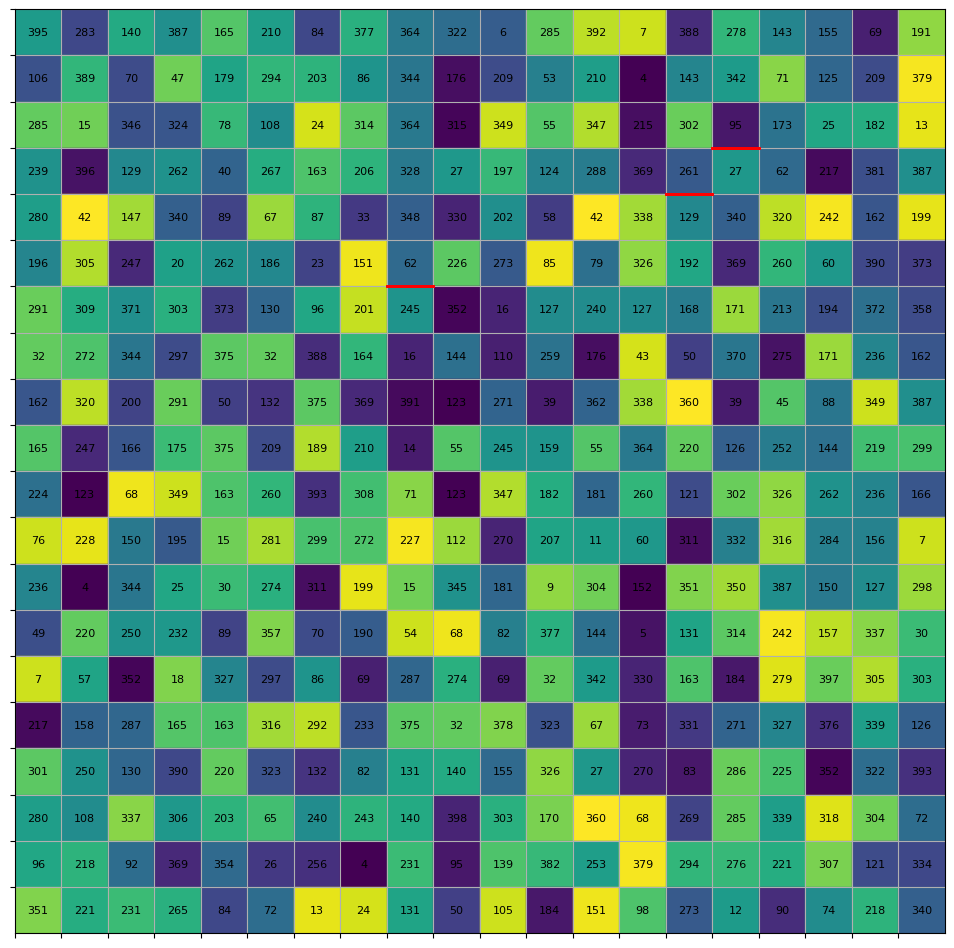

In [14]:
model_untrained = SeatingArrangementNet(num_people).to('cuda')
#  Generate example output from the model
model_untrained.eval()
with torch.no_grad():
    logits = model_untrained(input_matrix.view(1, -1).to('cuda'))
    seating_probabilities = F.softmax(logits, dim=-1)
    seating_arrangement = seating_probabilities.argmax(dim=-1).squeeze()

visualize_seating_arrangement(seating_arrangement, conflict_matrix, groups, num_people=400)

In [ ]:
import torch
import torch.nn.functional as F

def compute_loss(P_hat, input_matrix, conflict_matrix, assignment_weight=1.0, conflict_weight=1.0, group_weight=1.0, alpha=1):
    """
    Compute the loss for the given placement matrix and input matrix (combination of conflict matrix and groups matrix).

    Parameters:
    - P_hat: The predicted placement matrix (batch_size, 400, 400)
    - input_matrix: The conflict matrix (batch_size, 400, 400)
    - assignment_weight: Weight for the assignment loss
    - conflict_weight: Weight for the conflict loss
    - group_weight: Weight for the group loss

    Returns:
    - loss: The computed loss value
    """
    batch_size = P_hat.size(0)
    n = P_hat.size(1)  # This should be 400

     # Apply softmax to logits to get probabilities
    P = torch.softmax(P_hat, dim=2)

    # Assignment loss
    row_sum_loss = F.mse_loss(torch.sum(P, dim=2), torch.ones(batch_size, n, device=P.device))
    col_sum_loss = F.mse_loss(torch.sum(P, dim=1), torch.ones(batch_size, n, device=P.device))
    assignment_loss = row_sum_loss + col_sum_loss

    # Conflict loss
    conflict_loss = 0
    conflict_matrix = conflict_matrix.detach()
    for b in range(batch_size):
        P_batch = P[b]
        P_t = P_batch.transpose(0, 1)
        C = torch.matmul(torch.matmul(P_batch, conflict_matrix[b].float()), P_t)

        for i in range(20):
            for j in range(20):
                current_index = i * 20 + j
                if j < 19:  # Right neighbor
                    right_index = i * 20 + (j + 1)
                    conflict_loss += C[current_index, right_index]
                if i < 19:  # Front neighbor
                    front_index = (i + 1) * 20 + j
                    conflict_loss += C[current_index, front_index]
                if j > 0:  # Left neighbor
                    left_index = i * 20 + (j - 1)
                    conflict_loss += C[current_index, left_index]
                if i > 0:  # Back neighbor
                    back_index = (i - 1) * 20 + j
                    conflict_loss += C[current_index, back_index]

    # Normalize conflict loss
    conflict_loss /= (batch_size)

    # Group loss
    group_loss = 0
    counts = P_hat.exp()
    probs = counts / counts.sum(1, keepdims=True)
    for b in range(batch_size):
        # P = probs[b]
        # for i in range(400):
        #     for j in range(399):
        #         seat = j

        #         group_probs = P[input_matrix[b, i] == 1, seat + 1]
        #         conflict_probs = P[input_matrix[b, i] == -1, seat + 1]

        #         # Ensure no zero probabilities
        #         group_probs = torch.clamp(group_probs, min=1e-9)
        #         conflict_probs = torch.clamp(conflict_probs, min=1e-9)

        #         group_loss += -P[i,seat]*group_probs.log().sum()
        #         group_loss += P[i,seat]*conflict_probs.log().sum()
        P_batch = probs[b]
        for i in range(399):
            group_probs = P_batch[input_matrix[b, i] == 1, 1:400]
            conflict_probs = P_batch[input_matrix[b, i] == -1, 1:400]
            # Ensure no zero probabilities
            group_probs = torch.clamp(group_probs, min=1e-9)
            conflict_probs = torch.clamp(conflict_probs, min=1e-9)
            # print("group_probs shape:", group_probs.shape)
            # print("conflict probes shape:", conflict_probs.shape)
            # print("p batch shape:", P_batch[i,0:399].shape)
            # print("group probs log shape", group_probs.log().shape)
            group_loss += -alpha*(P_batch[i,0:399]*group_probs.log()).sum()
            group_loss += (1-alpha)*(P_batch[i,0:399]*conflict_probs.log()).sum()
            # print("group_loss shape", group_loss.shape)

    # Normalize group loss
    group_loss /= (batch_size*400)

    # Total loss with weights
    total_loss = (assignment_weight * assignment_loss) + (conflict_weight * conflict_loss) + (group_weight * group_loss)
    print("total_loss:", total_loss.item(), " assignment_loss: ", assignment_loss.item(), "conflict_loss: ", conflict_loss.item(), "group_loss: ", group_loss.item())
    return total_loss
